In [1]:
import numpy as np
from random import randint
import matplotlib.pyplot as plt
import corner
import json

import pytensor
from pytensor import tensor as pt
from pytensor.graph.basic import Apply

from pytensor.graph import Apply, Op
from pytensor.tensor.type import TensorType

import jax
from jax import grad, jit, vmap, value_and_grad, random
import jax.numpy as jnp

import pyhf
pyhf.set_backend('jax')
# pyhf.set_backend('numpy')

import pymc as pm
import arviz as az

from pyhf_pymc import prepare_inference
from pyhf_pymc import actual_inference

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


### Model

In [2]:
N = 3
nBins = N
obs = jnp.array([70.]*N)
model = pyhf.simplemodels.correlated_background([10]*N,[50]*N,[45]*N,[45]*N)

n_samples = 100_000

unconstr_dict = {
    'mu': {'type': 'unconstrained', 'input': [[5.], [1.]]}
}
prior_dict = prepare_inference.prepare_priors(model, unconstr_dict)
precision = []
[precision.append(float(obs[i])**(0.5)) for i in range(nBins)]
prepared_model = prepare_inference.prepare_model(model=model, observations=obs, precision=precision, priors=prior_dict)

In [3]:
expData_op = actual_inference.make_op(model)

### Simple Inference

In [4]:
post_data, post_pred, prior_pred = actual_inference.sampling(prepared_model, expData_op, draws=1000, chains=2, step_method='NUTS_with_advi', tune=1000 )

Auto-assigning NUTS sampler...
Initializing NUTS using advi...


Convergence achieved at 7300
Interrupted at 7,299 [3%]: Average Loss = 18.554
Interrupted at 7,299 [3%]: Average Loss = 18.554
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [Unconstrained, Normals]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 1 seconds.


Sampling: [Expected_Data, Normals, Unconstrained]


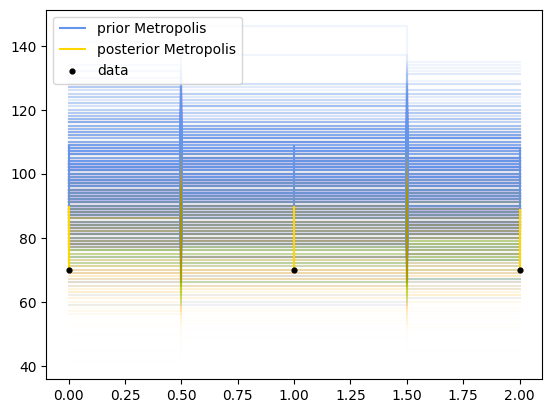

In [9]:
# Prior
plt.step(np.linspace(0,nBins-1,nBins),prior_pred.prior_predictive.Expected_Data[0].T, alpha = 0.1, c = 'cornflowerblue', where = 'mid');
plt.vlines(np.arange(nBins),*np.quantile(prior_pred.prior_predictive.Expected_Data[0],[.15,.85],axis=0), colors = 'cornflowerblue', label='prior Metropolis');

# Posterior
plt.step(np.linspace(0,nBins-1,nBins),post_pred.posterior_predictive.Expected_Data[0].T, alpha = 0.01, c = 'gold', where = 'mid');
plt.vlines(np.arange(nBins),*np.quantile(post_pred.posterior_predictive.Expected_Data[0],[.15,.85],axis=0), colors = 'gold', label='posterior Metropolis')

# Observations
plt.scatter(np.arange(nBins), obs, c = 'k',s=12, zorder = 999, label = "data")
plt.legend(loc='upper left')

plt.title(f'')

# plt.savefig('')
plt.show()

### Parameter Correlation for Different Backgrounds

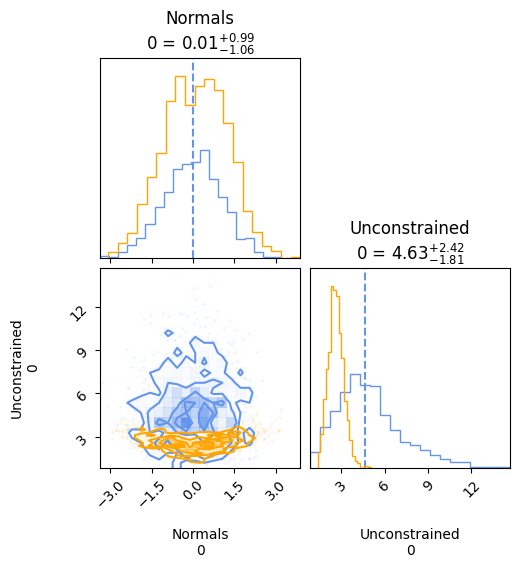

In [5]:
# Parameter Corner Plots
a = corner.corner(prior_pred.prior, quantiles=[0.5], show_titles=True, color='cornflowerblue')
corner.corner(post_data.posterior, color = 'orange', fig=a);

### Convergence Posterior to Prior

In [ ]:
obs_from_prior = obs
n_samples = 100
iterations = 100
# post = []
post_exp = []

import random

for i in range(iterations):
    post_data, post_pred, prior_pred = actual_inference.sampling(prepared_model, expData_op, draws=100, chains=1, step_method='NUTS_with_jitter' )

    # Generating pseudo-data from prior and update the prepared_model
    ii = randint(0, 100 - 1)
    obs_from_prior = prior_pred.prior_predictive.Expected_Data[0][ii] 
    
    prepared_model = prepare_inference.prepare_model(model=model, observations=obs_from_prior, precision=precision, priors=prior_dict)

    post_exp.append(np.asarray(post_pred.posterior_predictive.Expected_Data[0]))


all_post_averages = []

for i in range(iterations):
    average_per_iteration = []
    for b in range(nBins):
        aa = 0
        for ii in range(100):
            aa = aa + post_exp[i][ii][b]
        average_per_iteration.append(aa/n_samples)
    all_post_averages.append(average_per_iteration)

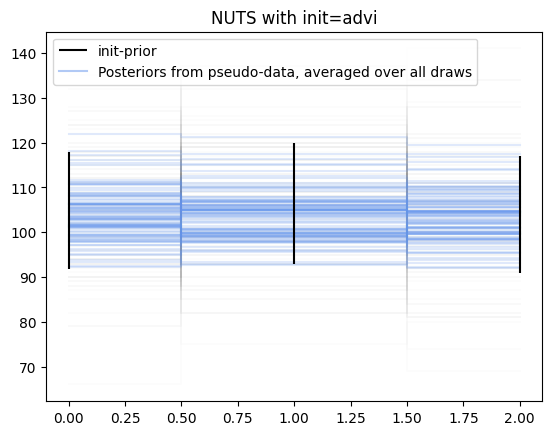

In [12]:
# Prior
plt.step(np.linspace(0,nBins-1,nBins),prior_pred.prior_predictive.Expected_Data[0].T, alpha = 0.01, c = 'black', where = 'mid');
plt.vlines(np.arange(nBins),*np.quantile(prior_pred.prior_predictive.Expected_Data[0],[.15,.85],axis=0), colors = 'black', label='init-prior', zorder=1900);

# Posterior
plt.step(np.linspace(0,nBins-1,nBins),np.asarray(all_post_averages[i]).T, alpha = 0.5, c = 'cornflowerblue', where = 'mid', label='Posteriors from pseudo-data, averaged over all draws')


for i in np.linspace(1, int(iterations-1), int(iterations-1), dtype=int):
    plt.step(np.linspace(0,nBins-1,nBins),np.asarray(all_post_averages[i]).T, alpha = 0.2, c = 'cornflowerblue', where = 'mid')

plt.title('NUTS with init=advi')
plt.legend(loc='upper left')

### Autocorrelation

In [11]:
post_data, post_pred, prior_pred = actual_inference.sampling(prepared_model, expData_op, draws=1000, chains=1, step_method='Metropolis', tune='..' )

Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [Expected_Data, Normals, Unconstrained]


array([<AxesSubplot: title={'center': 'Normals\n0, 0'}>,
       <AxesSubplot: title={'center': 'Unconstrained\n0, 0'}>],
      dtype=object)

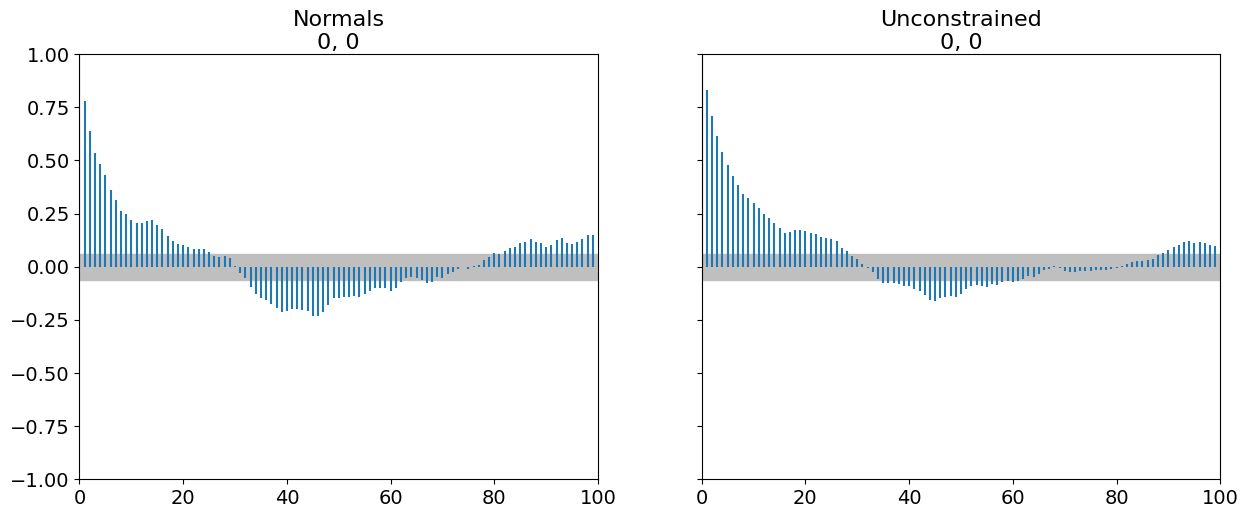

In [12]:
az.plot_autocorr(post_data)

In [4]:
post_data, post_pred, prior_pred = actual_inference.sampling(prepared_model, expData_op, draws=1000, chains=1, step_method='NUTS_with_advi', tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using advi...


Convergence achieved at 7100
Interrupted at 7,099 [3%]: Average Loss = 19.362
Interrupted at 7,099 [3%]: Average Loss = 19.362


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 1 seconds.


Sampling: [Expected_Data, Normals, Unconstrained]


array([<AxesSubplot: title={'center': 'Normals\n0, 0'}>,
       <AxesSubplot: title={'center': 'Unconstrained\n0, 0'}>],
      dtype=object)

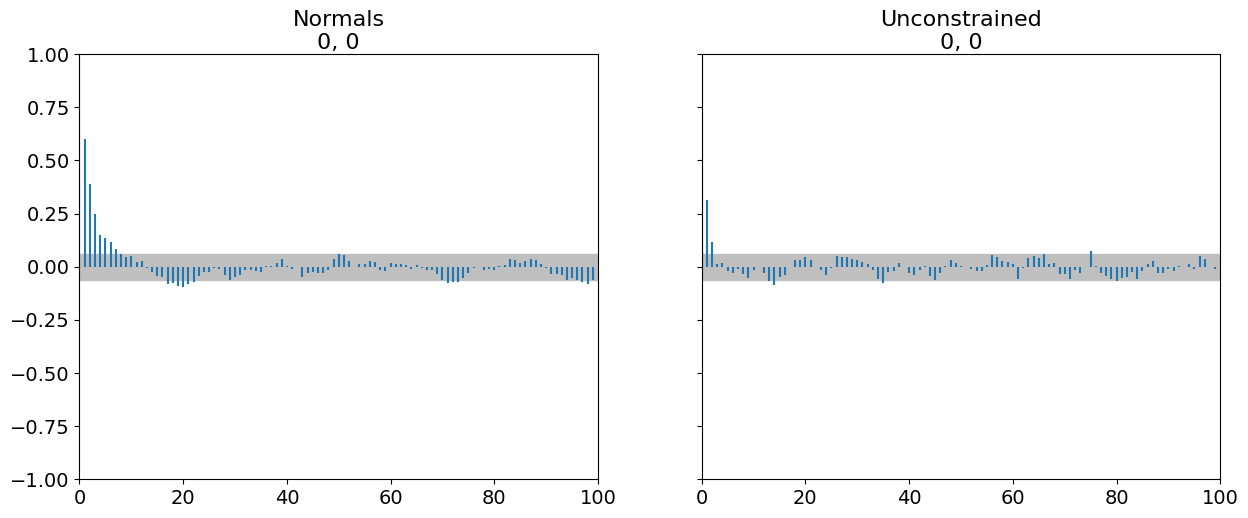

In [5]:
az.plot_autocorr(post_data, max_lag=100)

### Thinning

In [8]:
post_data, post_pred, prior_pred = actual_inference.sampling(prepared_model, expData_op, draws=1000, chains=1, step_method='Metropolis', tune='..' )

Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [Expected_Data, Normals, Unconstrained]


In [6]:
chains = 1
draws = 1000
tune=1000
step_method = 'NUTS_with_advi'
with pm.Model() as m:
    pars = prepare_inference.priors2pymc(prepared_model)

    Expected_Data = pm.Poisson("Expected_Data", mu=expData_op(pars), observed=obs)
    # Expected_Data = pm.Normal("Expected_Data", mu=expData_op(pars), sigma = precision, observed=obs)
    
    step1 = pm.Metropolis()
    # step2 = pm.NUTS()
    # step3 = pm.HamiltonianMC()
    
    if step_method == 'Metropolis':
        # post_data = pm.sample(chains = n_chains, draws=draws, cores=4, step=step1, progressbar=True)
        post_data = pm.sample(chains=chains, draws=draws, step=step1)
    if step_method == 'NUTS_with_advi':
        post_data = pm.sample(chains=chains, draws=draws, init='advi', tune=tune)
    if step_method == 'NUTS_with_jitter':
        post_data = pm.sample(chains=chains, draws=draws, tune=tune)

    post_pred = pm.sample_posterior_predictive(post_data)
    prior_pred = pm.sample_prior_predictive(draws)

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Initializing NUTS using advi...


Convergence achieved at 6600
Interrupted at 6,599 [3%]: Average Loss = 19.324
Interrupted at 6,599 [3%]: Average Loss = 19.324


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 1 seconds.


Sampling: [Expected_Data, Normals, Unconstrained]
